# Bridge condition change analysis

This notebook compares **two bridge datasets** (older `df1` vs newer `df2`) on the **bridge ID (`Bauwerksnummer`)** and focuses on changes in **condition rating (“Zustandsnote”, ZN)**.

## What the code does (step by step)

1. **Load two CSV files**
   - `df1`: older snapshot  
   - `df2`: newer snapshot (different delimiter/encoding supported)

2. **Standardize the merge key**
   - Ensures both datasets use `Bauwerksnummer`.

3. **Extract and clean core variables**
   - **Load class** (Traglastindex) converted from Roman numerals **I–V → 1–5**
   - **Last main inspection year** (filtered to plausible years)
   - **Condition rating (ZN)** as numeric
   - **Construction year** and **length**
     - `df1`: `Baujahr Überbau`, `Länge (m)`
     - `df2`: `baujahr`, `laenge`

4. **Aggregate to bridge level**
   - One row per `Bauwerksnummer` in each dataset (means/max where appropriate)

5. **Merge old vs new**
   - Keeps only bridges present in both (`inner` merge)
   - Builds unified `baujahr`/`laenge` by filling missing values across datasets

6. **Compute changes**
   - `dZN = zn2 − zn1`
   - Checks if `df2` is newer using the inspection year (`year2 − year1`)

7. **Create key plots**
   - **Plot 1:** Mean ΔZN vs starting ZN (binned in 0.1 steps) by load class, with 95% CI
   - **Plot 2:** “Stitched pseudotime” trajectories by load class (bootstrap CI)
   - Plus summary plots for:
     - **Overall ΔZN distribution + overall mean**
     - **How many bridges got a new main inspection** and the **year range** of those inspections


Order check using 'last main inspection year' (only where both years exist):
  n: 36017
  df2 newer (year2 > year1): 6656
  df1 newer (year1 > year2): 1
  equal: 29360

Merge quality (correlation df1 vs df2):
  corr(construction_year_df1, construction_year_df2): 0.9968535996501734  overlap: 36026
  corr(length_df1, length_df2): 0.9993603948425422  overlap: 36039

Overall ΔZN (all bridges with ZN in both datasets):
  n: 36039
  mean ΔZN: 0.01314511273139426



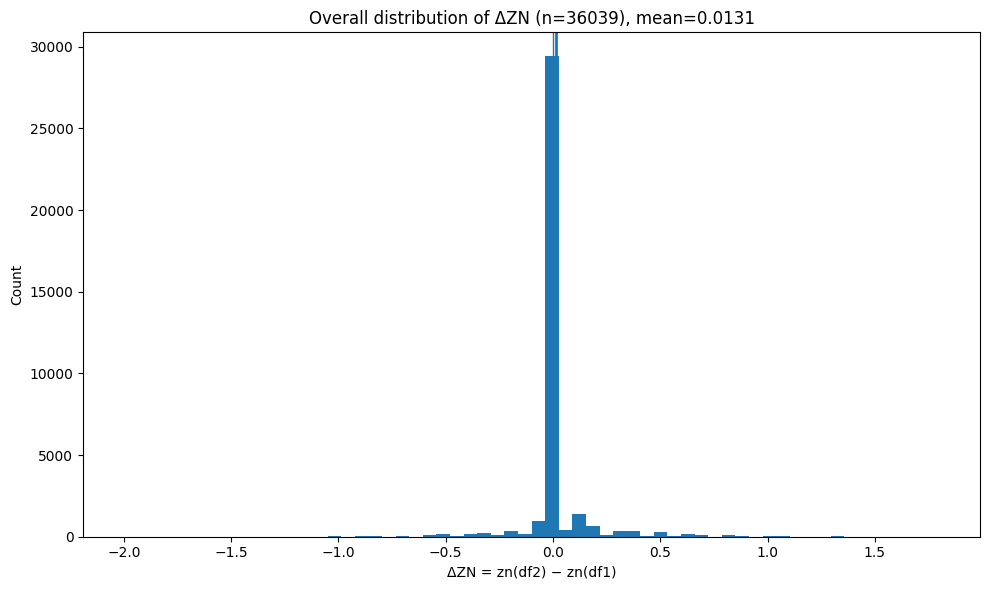

Bridges with a new main inspection (year2 > year1):
  n_new: 6656 out of 36017
  share among bridges with both years: 0.18480162145653442
  year2 range: 2020 to 2026



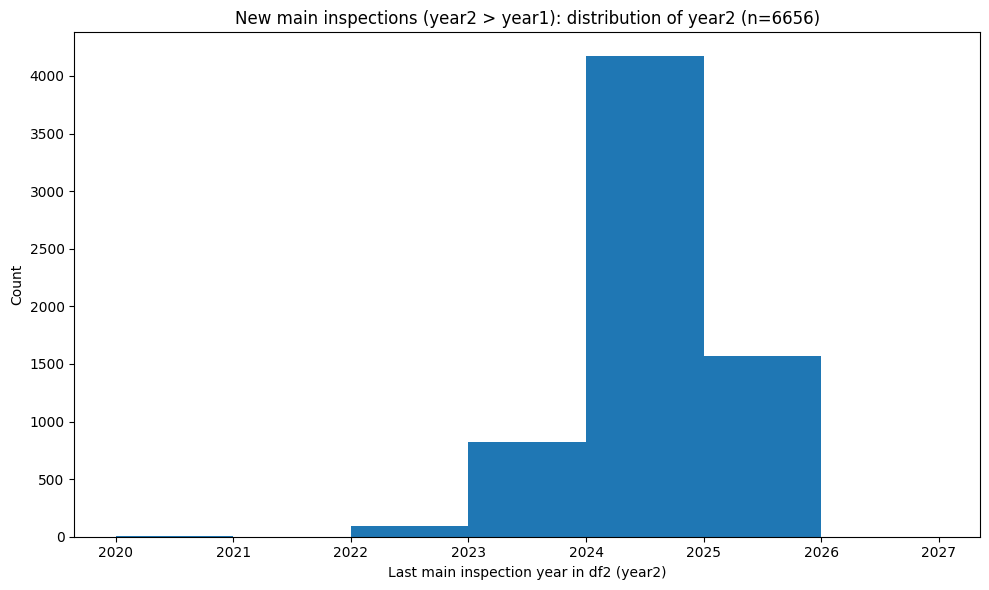

ZN (for Plot 1 & 2): n_total=36039 | n_used=9505 | zeros_included_due_to_new_inspection=2831


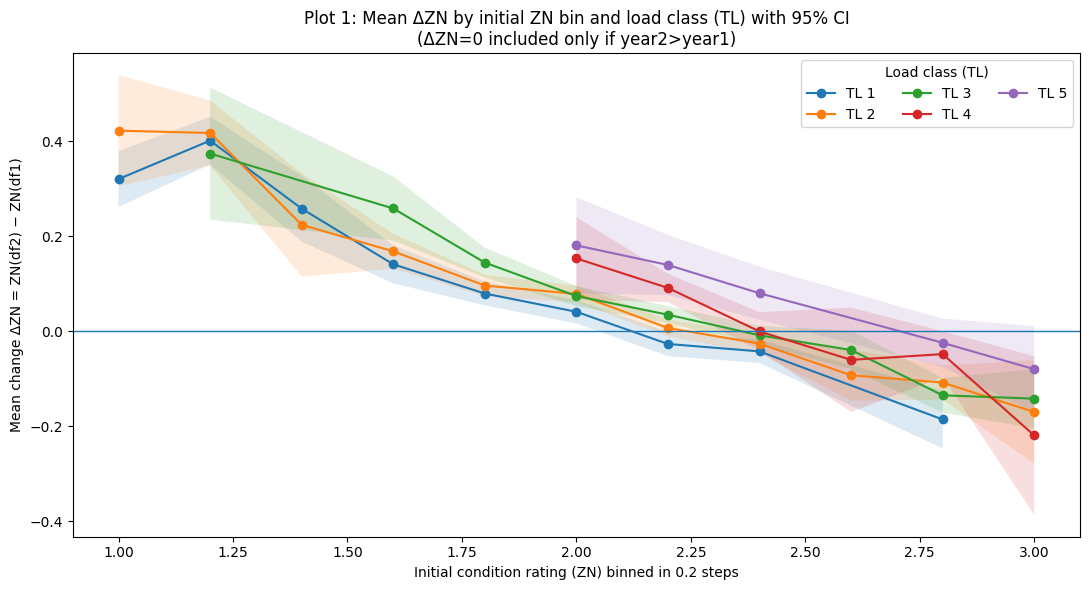

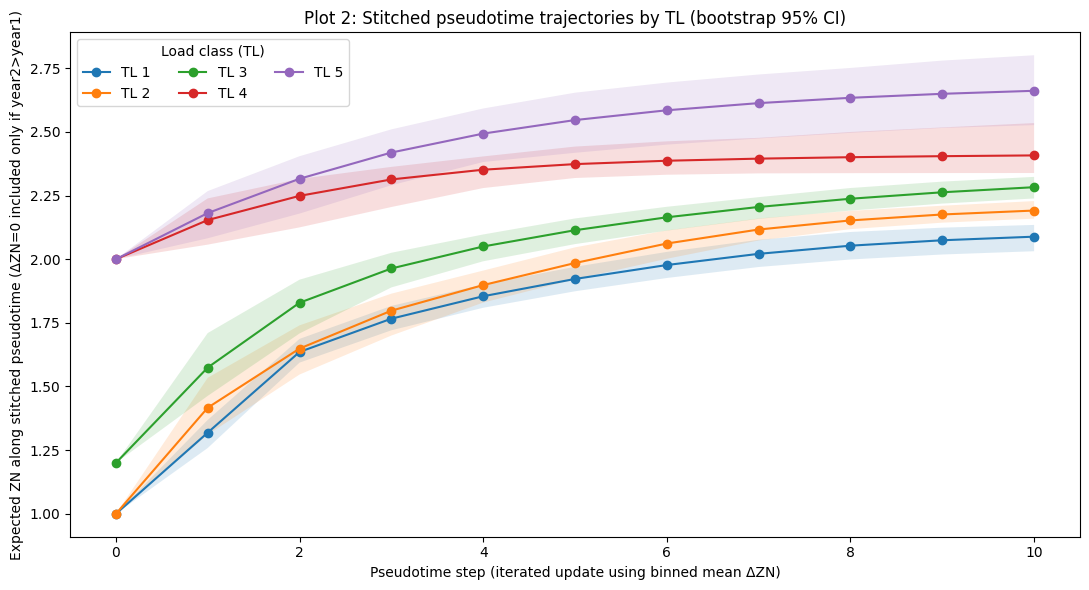

Bin coverage for ZN (after min_n filtering):
    TL  bins  min_bin  max_bin  n_in_bins
0  1.0     9      1.0      2.8       2438
1  2.0    11      1.0      3.0       3597
2  3.0     9      1.2      3.0       2331
3  4.0     6      2.0      3.0        492
4  5.0     5      2.0      3.0        396


In [ ]:
# ============================================
# Changes vs previous version:
# - Plot 1 & Plot 2 now INCLUDE dZN = 0 for bridges with a new main inspection (year2 > year1)
# - Everything still works if years are missing: zeros are included only when year_diff is known
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DF1_PATH = "/content/Brückenstatistik_Deutschland_2024.csv"
DF2_PATH = "/content/Brueckenstatistik-2025.csv"

df1 = pd.read_csv(DF1_PATH, sep=",", encoding="utf-8")
df2 = pd.read_csv(DF2_PATH, sep=";", encoding="latin1", engine="python", on_bad_lines="skip")

if "Bauwerksnummer" not in df1.columns:
    raise ValueError("df1: missing 'Bauwerksnummer'")
if "bwnr" in df2.columns:
    df2 = df2.rename(columns={"bwnr": "Bauwerksnummer"})
if "Bauwerksnummer" not in df2.columns:
    raise ValueError("df2: missing 'Bauwerksnummer'")

roman_map = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def tl_mode(df, tl_col):
    s = df[["Bauwerksnummer", tl_col]].dropna()
    if s.empty:
        return pd.Series(dtype=float)
    counts = s.groupby(["Bauwerksnummer", tl_col]).size().unstack(fill_value=0)
    return counts.idxmax(axis=1)

def corr_pair(a, b, min_n=50):
    mask = a.notna() & b.notna()
    n = int(mask.sum())
    if n < min_n:
        return np.nan, n
    r = float(np.corrcoef(a[mask], b[mask])[0, 1])
    return r, n

# ---- Prepare columns ----
df1["_TL"] = df1["Traglastindex"].map(roman_map) if "Traglastindex" in df1.columns else np.nan
df2["_TL"] = df2["trag_l_idx"].map(roman_map)    if "trag_l_idx" in df2.columns else np.nan

df1["_year"] = to_num(df1.get("Jahr letzte Hauptprüfung")).where(lambda s: s.between(1900, 2100))
df2["_year"] = to_num(df2.get("jahr_letzte_hauptpruefung")).where(lambda s: s.between(1900, 2100))

df1["_ZN"] = to_num(df1.get("Zustandsnote"))
df2["_ZN"] = to_num(df2.get("zn"))

df1["_baujahr"] = to_num(df1["Baujahr Überbau"]).where(lambda s: s.between(1800, 2100)) if "Baujahr Überbau" in df1.columns else np.nan
df2["_baujahr"] = to_num(df2["baujahr"]).where(lambda s: s.between(1800, 2100))         if "baujahr" in df2.columns else np.nan

df1["_laenge"] = to_num(df1["Länge (m)"]) if "Länge (m)" in df1.columns else np.nan
df2["_laenge"] = to_num(df2["laenge"])    if "laenge" in df2.columns else np.nan

# ---- Aggregate ----
agg1 = df1.groupby("Bauwerksnummer", as_index=False).agg(
    year1=("_year", "max"),
    zn1=("_ZN", "mean"),
    baujahr1=("_baujahr", "max"),
    laenge1=("_laenge", "mean"),
)
agg2 = df2.groupby("Bauwerksnummer", as_index=False).agg(
    year2=("_year", "max"),
    zn2=("_ZN", "mean"),
    baujahr2=("_baujahr", "max"),
    laenge2=("_laenge", "mean"),
)

tl1 = tl_mode(df1, "_TL").rename("TL1").reset_index()
tl2 = tl_mode(df2, "_TL").rename("TL2").reset_index()

m = (
    agg1.merge(agg2, on="Bauwerksnummer", how="inner")
        .merge(tl1, on="Bauwerksnummer", how="left")
        .merge(tl2, on="Bauwerksnummer", how="left")
)

m["TL"] = m["TL1"].fillna(m["TL2"])
m = m.dropna(subset=["TL"])
m = m[m["TL"].between(1, 5)].copy()

m["baujahr"] = m["baujahr1"].fillna(m["baujahr2"])
m["laenge"]  = m["laenge1"].fillna(m["laenge2"])

m["dZN"] = m["zn2"] - m["zn1"]

#  Year change flags
m["year_diff"] = m["year2"] - m["year1"]
m["has_both_years"] = m["year1"].notna() & m["year2"].notna()
m["new_main_inspection"] = m["has_both_years"] & (m["year_diff"] > 0)

print("Order check using 'last main inspection year' (only where both years exist):")
my = m[m["has_both_years"]].copy()
print("  n:", len(my))
print("  df2 newer (year2 > year1):", int((my["year_diff"] > 0).sum()))
print("  df1 newer (year1 > year2):", int((my["year_diff"] < 0).sum()))
print("  equal:", int((my["year_diff"] == 0).sum()))
print()

# ---- Merge quality ----
rbj, nbj = corr_pair(m["baujahr1"], m["baujahr2"])
rle, nle = corr_pair(m["laenge1"], m["laenge2"])
print("Merge quality (correlation df1 vs df2):")
print("  corr(construction_year_df1, construction_year_df2):", rbj, " overlap:", nbj)
print("  corr(length_df1, length_df2):", rle, " overlap:", nle)
print()

# ---- Overall ΔZN (all with both ZN) ----
d_all = m.dropna(subset=["zn1", "zn2"]).copy()
d_all["dZN"] = d_all["zn2"] - d_all["zn1"]

mu = float(d_all["dZN"].mean())
print("Overall ΔZN (all bridges with ZN in both datasets):")
print("  n:", len(d_all))
print("  mean ΔZN:", mu)
print()

plt.figure(figsize=(10, 6))
plt.hist(d_all["dZN"].dropna(), bins=60)
plt.axvline(0, linewidth=1)
plt.axvline(mu, linewidth=2)
plt.xlabel("ΔZN = zn(df2) − zn(df1)")
plt.ylabel("Count")
plt.title(f"Overall distribution of ΔZN (n={len(d_all)}), mean={mu:.4f}")
plt.tight_layout()
plt.show()

# ---- New main inspections summary ----
new_inspections = m[m["new_main_inspection"]].copy()
print("Bridges with a new main inspection (year2 > year1):")
print("  n_new:", len(new_inspections), "out of", len(my))
if len(my) > 0:
    print("  share among bridges with both years:", len(new_inspections) / len(my))
if len(new_inspections) > 0:
    y2 = new_inspections["year2"].dropna().astype(int)
    print("  year2 range:", int(y2.min()), "to", int(y2.max()))
print()

if len(new_inspections) > 0:
    y = new_inspections["year2"].dropna().astype(int)
    if len(y) > 0:
        plt.figure(figsize=(10, 6))
        bins = np.arange(int(y.min()), int(y.max()) + 2)
        plt.hist(y, bins=bins)
        plt.xlabel("Last main inspection year in df2 (year2)")
        plt.ylabel("Count")
        plt.title(f"New main inspections (year2 > year1): distribution of year2 (n={len(y)})")
        plt.tight_layout()
        plt.show()

# ============================================
# Plot 1 + Plot 2 (UPDATED inclusion rule)
# Include:
# - all bridges with ΔZN != 0
# - PLUS bridges with ΔZN == 0 if they have new main inspection (year2 > year1)
# ============================================

def analyze_zn_include_zeros_for_new_inspections(
    m, bin_w=0.2, min_n=30, Tmax=10, B=250, seed=2, support_min=80
):
    d = m.dropna(subset=["zn1", "zn2", "TL"]).copy()
    d["delta"] = d["zn2"] - d["zn1"]

    include_zero = d["new_main_inspection"].fillna(False)
    use = (d["delta"] != 0) | ((d["delta"] == 0) & include_zero)
    d_use = d[use].copy()

    n_total = len(d)
    n_use = len(d_use)
    n_zero_included = int(((d_use["delta"] == 0) & (d_use["new_main_inspection"])).sum())

    print(f"ZN (for Plot 1 & 2): n_total={n_total} | n_used={n_use} | zeros_included_due_to_new_inspection={n_zero_included}")

    # Bin by initial ZN
    d_use["bin"] = (np.round(d_use["zn1"] / bin_w) * bin_w).round(1)

    stats = (
        d_use.groupby(["TL", "bin"])["delta"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    stats["se"] = stats["std"] / np.sqrt(stats["count"])
    stats["ci95"] = 1.96 * stats["se"]
    stats["lo"] = stats["mean"] - stats["ci95"]
    stats["hi"] = stats["mean"] + stats["ci95"]
    stats_f = stats[stats["count"] >= min_n].copy()

    # ---- Plot 1 ----
    plt.figure(figsize=(11, 6))
    for tl in [1, 2, 3, 4, 5]:
        s = stats_f[stats_f["TL"] == tl].sort_values("bin")
        if s.empty:
            continue
        x = s["bin"].to_numpy()
        y = s["mean"].to_numpy()
        lo = s["lo"].to_numpy()
        hi = s["hi"].to_numpy()
        plt.plot(x, y, marker="o", label=f"TL {tl}")
        plt.fill_between(x, lo, hi, alpha=0.15)

    plt.axhline(0, linewidth=1)
    plt.xlabel(f"Initial condition rating (ZN) binned in {bin_w} steps")
    plt.ylabel("Mean change ΔZN = ZN(df2) − ZN(df1)")
    plt.title("Mean ΔZN by initial ZN bin and load class")
    plt.legend(ncol=3, frameon=True, title="Load class (TL)")
    plt.tight_layout()
    plt.show()

    # ---- Plot 2: stitched pseudotime with bootstrap ----
    rng = np.random.default_rng(seed)

    def make_interp(x, y):
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        order = np.argsort(x)
        x = x[order]
        y = y[order]

        def f(z):
            z = float(z)
            if len(x) < 2 or z < x.min() or z > x.max():
                return np.nan
            return float(np.interp(z, x, y))
        return f, float(x.min()), float(x.max())

    traj_boot = {tl: [] for tl in [1, 2, 3, 4, 5]}
    base_bins = {tl: sorted(stats_f[stats_f["TL"] == tl]["bin"].unique()) for tl in [1, 2, 3, 4, 5]}

    for tl in [1, 2, 3, 4, 5]:
        df_tl = d_use[d_use["TL"] == tl][["bin", "delta"]].copy()
        if df_tl.empty or len(base_bins[tl]) < 2:
            continue

        z0 = min(base_bins[tl])
        idx = np.arange(len(df_tl))

        for _ in range(B):
            samp = df_tl.iloc[rng.choice(idx, size=len(df_tl), replace=True)]
            g = samp.groupby("bin")["delta"].agg(["mean", "count"]).reset_index()
            g = g[g["count"] >= min_n].copy()
            g = g[g["bin"].isin(base_bins[tl])].sort_values("bin")
            if len(g) < 2:
                continue

            f, zmin, zmax = make_interp(g["bin"], g["mean"])
            z = z0
            zs = [z]

            for _t in range(Tmax):
                dlt = f(z)
                if not np.isfinite(dlt):
                    break
                z_next = z + dlt
                if not np.isfinite(z_next) or z_next < zmin or z_next > zmax:
                    break
                zs.append(z_next)
                z = z_next

            traj_boot[tl].append(np.array(zs))

    ci = {}
    for tl, arrs in traj_boot.items():
        if len(arrs) < 30:
            continue
        maxlen = min(max(len(a) for a in arrs), Tmax + 1)
        M = np.full((len(arrs), maxlen), np.nan, dtype=float)
        for i, a in enumerate(arrs):
            L = min(len(a), maxlen)
            M[i, :L] = a[:L]

        mean = np.nanmean(M, axis=0)
        lo = np.nanquantile(M, 0.025, axis=0)
        hi = np.nanquantile(M, 0.975, axis=0)
        n_eff = np.sum(~np.isnan(M), axis=0)
        ci[tl] = {"mean": mean, "lo": lo, "hi": hi, "n_eff": n_eff}

    plt.figure(figsize=(11, 6))
    for tl in [1, 2, 3, 4, 5]:
        if tl not in ci:
            continue
        y = ci[tl]["mean"]
        lo = ci[tl]["lo"]
        hi = ci[tl]["hi"]
        n_eff = ci[tl]["n_eff"]

        last = len(y) - 1
        if (n_eff < support_min).any():
            idx0 = np.argmax(n_eff < support_min)
            last = max(0, idx0 - 1)

        x = np.arange(last + 1)
        plt.plot(x, y[: last + 1], marker="o", label=f"TL {tl}")
        plt.fill_between(x, lo[: last + 1], hi[: last + 1], alpha=0.15)

    plt.xlabel("Pseudotime step (iterated update using binned mean ΔZN)")
    plt.ylabel("Expected ZN along stitched pseudotime (ΔZN=0 included only if year2>year1)")
    plt.title("Plot 2: Stitched pseudotime trajectories by TL (bootstrap 95% CI)")
    plt.legend(ncol=3, frameon=True, title="Load class (TL)")
    plt.tight_layout()
    plt.show()

    bin_cov = (
        stats_f.groupby("TL")
        .agg(
            bins=("bin", "nunique"),
            min_bin=("bin", "min"),
            max_bin=("bin", "max"),
            n_in_bins=("count", "sum"),
        )
        .reset_index()
        .sort_values("TL")
    )

    return d_use, stats_f, bin_cov

d_use, ZN_stats_f, ZN_bin_cov = analyze_zn_include_zeros_for_new_inspections(m, seed=2)

print("Bin coverage for ZN (after min_n filtering):")
print(ZN_bin_cov)


